In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.cElementTree as ET
import glob 
import os
import json
import random 
import shutil 

from PIL import Image, ImageOps

In [3]:
len(glob.glob('/kaggle/input/face-mask-detection/images/*'))

853

In [4]:
with open('/kaggle/input/face-mask-detection/annotations/maksssksksss10.xml') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss10.png</filename>
    <size>
        <width>301</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>98</xmin>
            <ymin>267</ymin>
            <xmax>194</xmax>
            <ymax>383</ymax>
        </bndbox>
    </object>
</annotation>


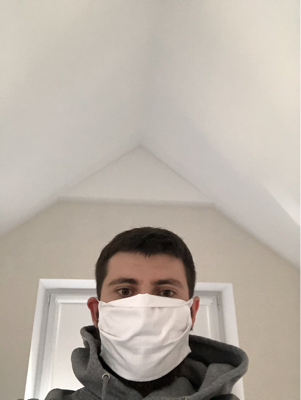

In [5]:
Image.open("/kaggle/input/face-mask-detection/images/maksssksksss10.png")

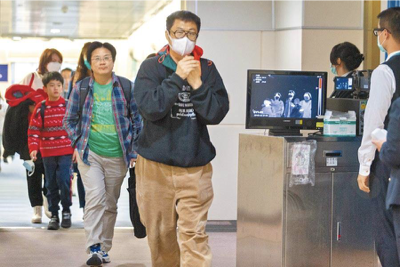

In [6]:
Image.open('/kaggle/input/face-mask-detection/images/maksssksksss179.png')

In [7]:
# Перевод XML-формат в TXT-формат
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0])/2)/w
    y_center = ((bbox[3] + bbox[1])/2)/h
    
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    
    return [x_center, y_center, width, height]

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center, width, height
    w_half_len = (bbox[2] * w)/2
    h_half_len = (bbox[3] * h)/2
    
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    
    return [xmin, ymin, xmax, ymax]

classes = ["without_mask", "with_mask", "mask_weared_incorrect"] # классы

input_dir = "/kaggle/input/face-mask-detection/annotations"
output_dir = "/kaggle/working/labels"
image_dir = "/kaggle/input/face-mask-detection/images"

if not os.path.isdir(output_dir): # создане папки для выхода
    os.mkdir(output_dir)
import glob 

files = glob.glob(os.path.join(input_dir, "*.xml")) # соединение в путь, хотя можно просто было папку указать
                                                    # и через всписковые включения загнать в str
# аналог glob.glob("/kaggle/input/face-mask-detection/annotations/*.xml")
for fil in files:
    basename = os.path.basename(fil) # достает имя файла с расширением
    # аналог fil.split('/')[-1]
    filename = os.path.splitext(basename)[0] # типа кортежа из 2-х частей: ('имя_файла', '.txt')
    # аналог basename.split('.')[0]
    #---------------------------------------------------------------------
    # блок проверки: типа если существует картинка с таким же названием, то работаем, иначе пропускаем
    # os.path.exists - проверка наличия
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue 
    #---------------------------------------------------------------------
    result = []
    
    # Проанализируйте содержимое xml-файла
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)
    
    for obj in root.findall("object"): # цикл который ищет все метки с коробками
        label = obj.find("name").text 
        
        # Проверяет наличие новых классов и добавляет их в список
        if label not in classes:
            classes.append(label)
        index = classes.index(label) # выводит индекс класса в списке
        pil_bbox = [int(x.text) for x in obj.find("bndbox")] # типа достает [28, 55, 46, 71]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height) # типа преобразует в (x_центр, y_центр, w, h)
        # так выглядит выход:
#         [0.0925, 0.27876106194690264, 0.045, 0.07079646017699115]
#         [0.26125, 0.30973451327433627, 0.0325, 0.07079646017699115]
#         [0.44, 0.30973451327433627, 0.085, 0.17699115044247787]
        
        # преобразование данных в строку
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        # так выглядит выход:
#         0.0925 0.27876106194690264 0.045 0.07079646017699115
#         0.26125 0.30973451327433627 0.0325 0.07079646017699115
#         0.44 0.30973451327433627 0.085 0.17699115044247787
#         print(bbox_string)
        result.append(f"{index} {bbox_string}")
        # короче на выходе список строк с метками и коробками [x,y,w,h], разделенных пробелами
        # выводится для кадой картинки
        # ['1 0.0925 0.27876106194690264 0.045 0.07079646017699115', 
        #  '1 0.26125 0.30973451327433627 0.0325 0.07079646017699115']

#---------------------------------------------------------------------------------------------------------
# создаем файлы txt для каждой картинки с классами и коробками и файл txt c классами
    if result: 
        # создаем файлы txt для каждой картинки, в виде (формата yolo для каждого xml-файла):
#         1 0.625 0.3651685393258427 0.08 0.13857677902621723
#         1 0.8825 0.3089887640449438 0.075 0.12359550561797752
#         1 0.335 0.40074906367041196 0.075 0.14232209737827714
#         1 0.39 0.41198501872659177 0.05 0.0898876404494382
#         1 0.22125 0.4044943820224719 0.0575 0.1198501872659176
#         1 0.04125 0.46629213483146065 0.0725 0.12359550561797752
        with open(os.path.join(output_dir, f"{filename}.txt"), # создаем текстовый файл
                 "w", encoding = 'utf-8') as f:
            f.write("\n".join(result)) # записываем в файл данные, каждый в новой строке
            #_____________________________
#             print(f)

# создает файл txt с классами, здесь файл со списком: ["without_mask", "with_mask", "mask_weared_incorrect"]
with open("/kaggle/working/classes.txt", "w", encoding = 'utf-8') as f:
    f.write(json.dumps(classes)) # записывает файл типа json

In [8]:
# # Текстовая версия приведенной выше метки в формате XML
with open('/kaggle/working/labels/maksssksksss595.txt') as f:
    contents = f.read()
    print(contents)

1 0.13875 0.3258426966292135 0.0475 0.06741573033707865
1 0.315 0.3146067415730337 0.04 0.06741573033707865
1 0.4125 0.32209737827715357 0.04 0.0749063670411985
1 0.4575 0.2902621722846442 0.04 0.07116104868913857
1 0.62875 0.32397003745318353 0.0425 0.07116104868913857
1 0.75625 0.3295880149812734 0.0425 0.0749063670411985


# **Create Data For Yolov8**

In [9]:
# Название и создание файлов, подготовленных для Yolov8
# ЗДЕСЬ СОЗДАЕМ НЕОБХОДИМЫЕ ПАПКИ
if os.path.isfile('/kaggle/working/data'):
    print('There is  folder !')
else:
    os.mkdir('/kaggle/working/data')
os.mkdir('/kaggle/working/data/train')
os.mkdir('/kaggle/working/data/val')
os.mkdir('/kaggle/working/data/test')
os.mkdir('/kaggle/working/data/train/images')
os.mkdir('/kaggle/working/data/train/labels')
os.mkdir('/kaggle/working/data/test/images')
os.mkdir('/kaggle/working/data/test/labels')
os.mkdir('/kaggle/working/data/val/images')
os.mkdir('/kaggle/working/data/val/labels')

In [10]:
# Создаем список названий картинок без расширений
metarial = []

for i in os.listdir('/kaggle/input/face-mask-detection/images'):
    srt = i[:-4]
    metarial.append(srt)

In [11]:
metarial[:3]

['maksssksksss810', 'maksssksksss848', 'maksssksksss145']

In [12]:
# Короче распределяем картинки по папкам и файлы txt с аннотациями, коробки всякие
# для подачи в елу8.


def preparedata(main_txt_file, main_img_file, train_size, test_size, val_size):
    for i in range(0, train_size):
        source_txt = main_txt_file + "/" + metarial[i] + ".txt"
        source_img = main_img_file + "/" + metarial[i] + ".png"
        
        mstring = metarial[i]
        train_destination_txt = "/kaggle/working/data/train/labels" + "/" + metarial[i] + ".txt"
        train_destination_png = "/kaggle/working/data/train/images" + "/" + metarial[i] + ".png"
        
        shutil.copy(source_txt, train_destination_txt)
        shutil.copy(source_img, train_destination_png)
    
    for l in range(train_size, train_size + test_size):
        source_txt = main_txt_file + "/" + metarial[l] + ".txt"
        source_img = main_img_file + "/" + metarial[l] + ".png"
        
        mstring = metarial[l]
        test_destination_txt = "/kaggle/working/data/test/labels" + "/" + metarial[l] + ".txt"
        test_destination_png = "/kaggle/working/data/test/images" + "/" + metarial[l] + ".png"
        
        shutil.copy(source_txt, test_destination_txt)
        shutil.copy(source_txt, test_destination_png)
        
    
    for n in range(train_size + test_size, train_size + test_size + val_size):
        source_txt = main_txt_file + "/" + metarial[n] + ".txt"
        source_img = main_img_file + "/" + metarial[n] + ".png"
        
        mstring = metarial[n]
        val_destination_txt = "/kaggle/working/data/val/labels" + "/" + metarial[n] + ".txt"
        val_destination_png = "/kaggle/working/data/val/images" + "/" + metarial[n] + ".png"
        
        shutil.copy(source_txt, val_destination_txt)
        shutil.copy(source_img, val_destination_png)

In [13]:
preparedata("/kaggle/working/labels","/kaggle/input/face-mask-detection/images", 603, 150, 100)

In [14]:
# создали что-то типа текскового файла с данными yaml_text, прям и форма такая-же и больше ничего
yaml_text = """train: /kaggle/working/data/train/images
val: /kaggle/working/data/val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]"""

with open("/kaggle/working/data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [15]:
%cat /kaggle/working/data/data.yaml # типа что-то типа содержимого посмотрели штоли %cat што за такое, в инете нет

train: /kaggle/working/data/train/images
val: /kaggle/working/data/val/images

nc: 3
names: ["without_mask", "with_mask", "mask_weared_incorrect"]

# **Грузим модель елу8**

In [16]:
# мы устанавливаем библиотеку ultralytics, чтобы использовать библиотеку YoloV8
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 706.9 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.5/783.5 kB 6.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.36 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5689.4/8062.4 GB disk)


# **Обучение** типа

In [18]:
# типа папку с результатами создаем
if os.path.isfile('/kaggle/working/Result/'):
    print("There is result folder")
else:
    os.mkdir("/kaggle/working/Result/")

In [19]:
%cd /kaggle/working/Result/

/kaggle/working/Result


In [20]:
!yolo train model=yolov8n.pt data = /kaggle/working/data/data.yaml epochs = 50 imgsz = 640

100%|██████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 76.7MB/s]
Ultralytics YOLOv8.2.36 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=F

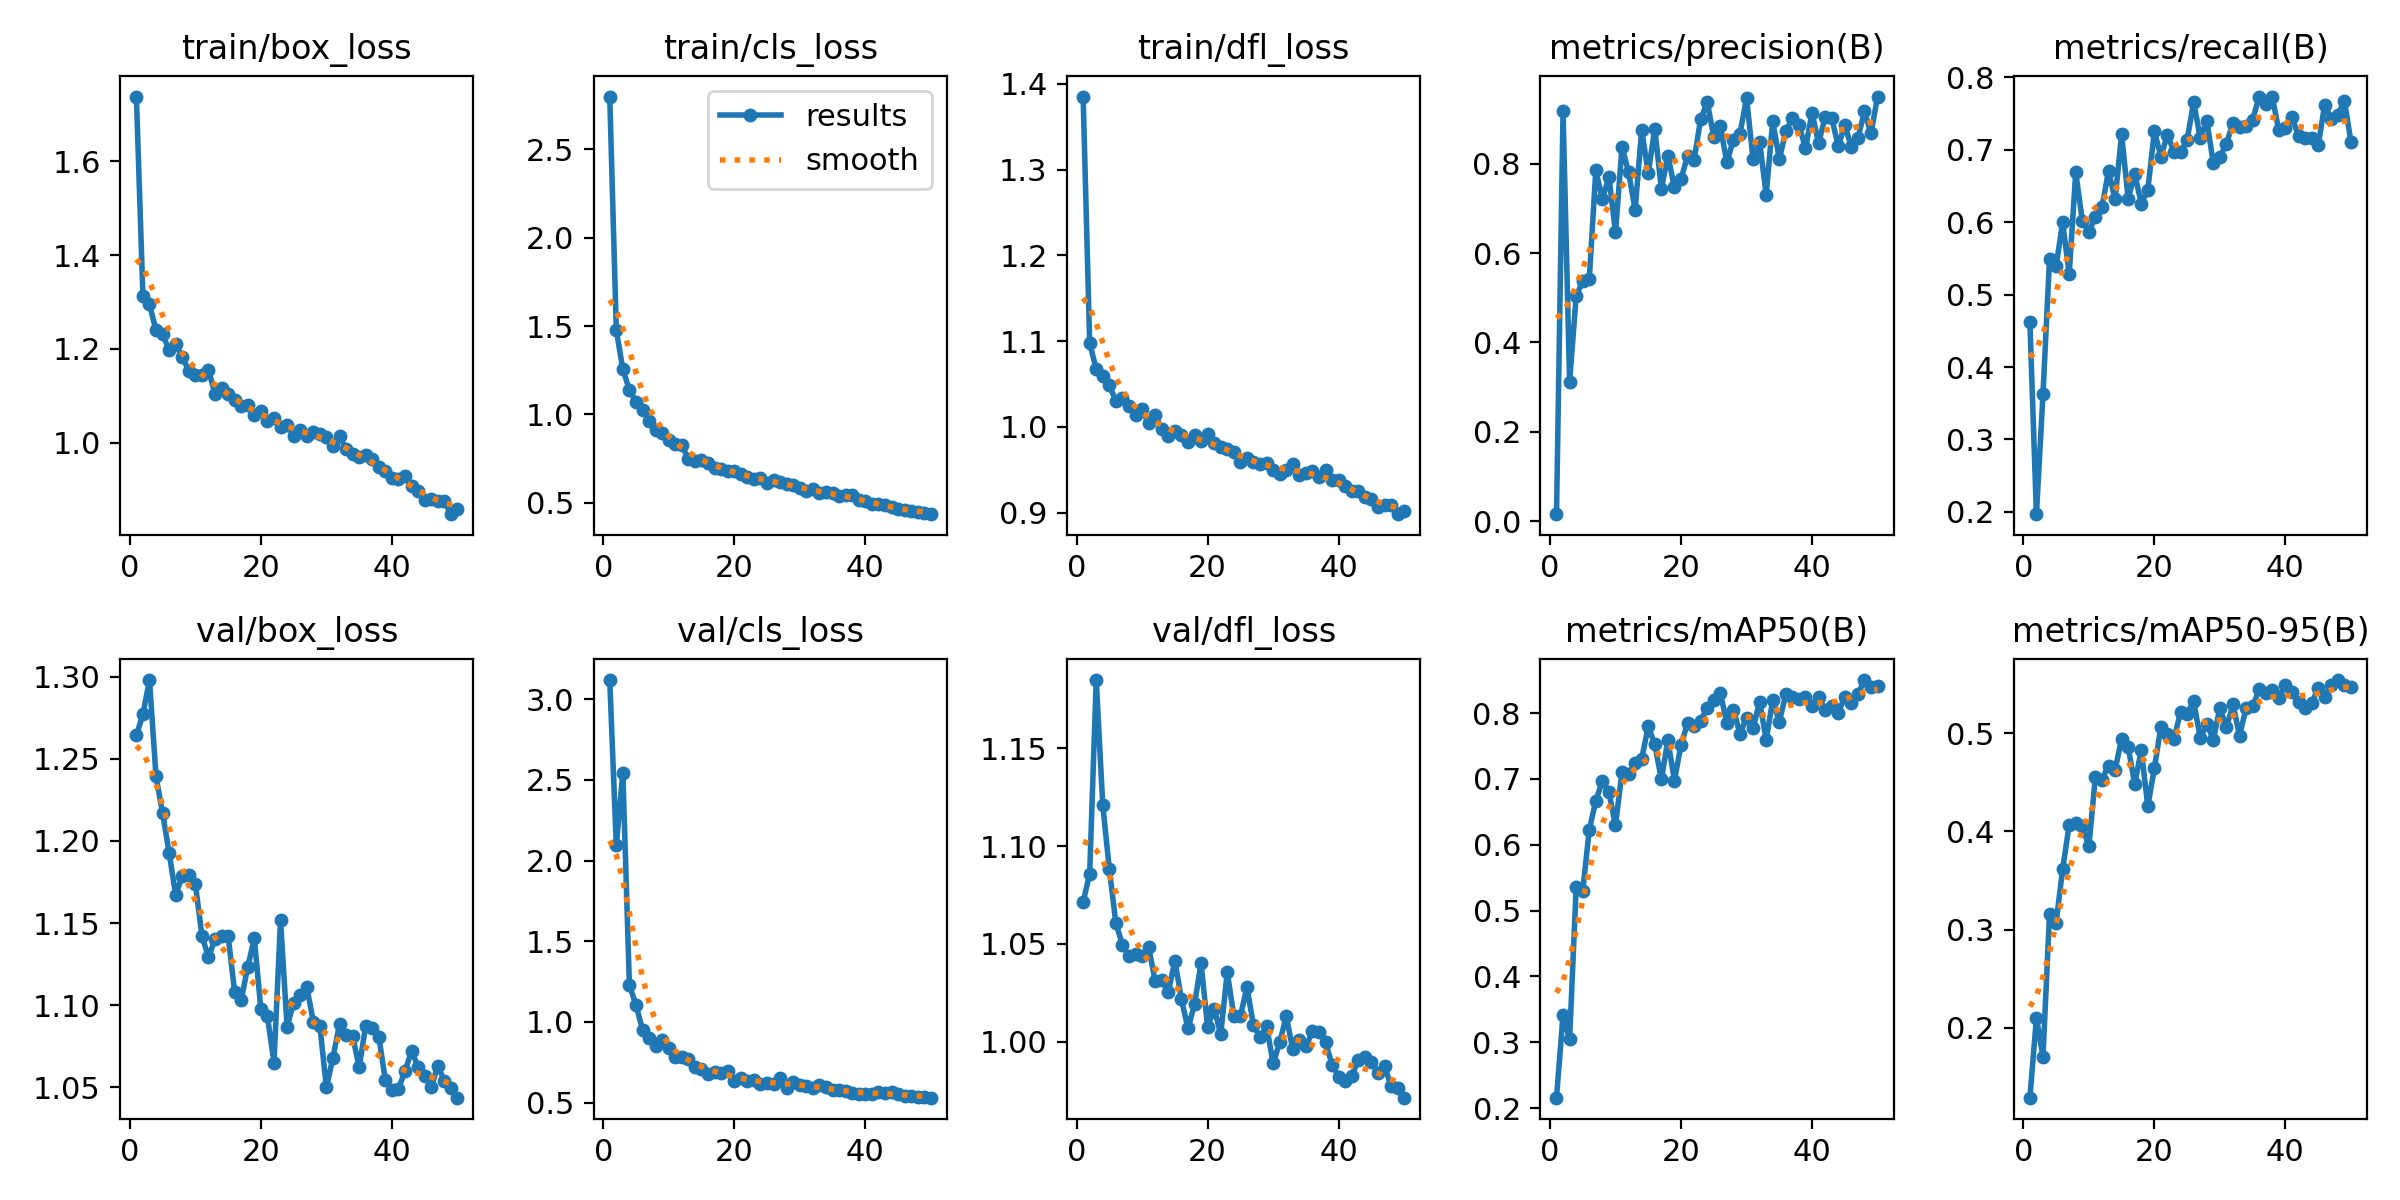

In [21]:
 Image.open("/kaggle/working/Result/runs/detect/train/results.png")

# **Detection**

In [22]:
# The detection process we performed on the test data set
!yolo predict model = /kaggle/working/Result/runs/detect/train/weights/best.pt  source='/kaggle/working/data/val/images'

Ultralytics YOLOv8.2.36 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs

image 1/100 /kaggle/working/data/val/images/maksssksksss101.png: 640x512 1 with_mask, 62.7ms
image 2/100 /kaggle/working/data/val/images/maksssksksss106.png: 448x640 (no detections), 57.7ms
image 3/100 /kaggle/working/data/val/images/maksssksksss109.png: 640x640 1 with_mask, 7.9ms
image 4/100 /kaggle/working/data/val/images/maksssksksss139.png: 384x640 1 without_mask, 17 with_masks, 1 mask_weared_incorrect, 75.9ms
image 5/100 /kaggle/working/data/val/images/maksssksksss14.png: 640x512 1 without_mask, 7.2ms
image 6/100 /kaggle/working/data/val/images/maksssksksss140.png: 448x640 2 with_masks, 6.9ms
image 7/100 /kaggle/working/data/val/images/maksssksksss141.png: 448x640 2 with_masks, 7.3ms
image 8/100 /kaggle/working/data/val/images/maksssksksss142.png: 480x640 1 with_mask, 58.0ms
image 9/100 /kaggle/working/data/val/images/maks

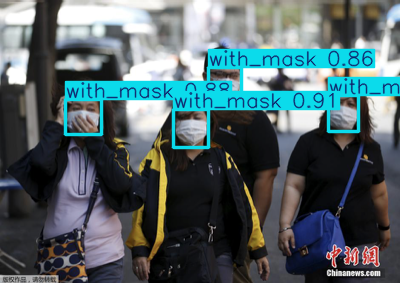

In [23]:
Image.open('/kaggle/working/Result/runs/detect/predict/maksssksksss450.png')

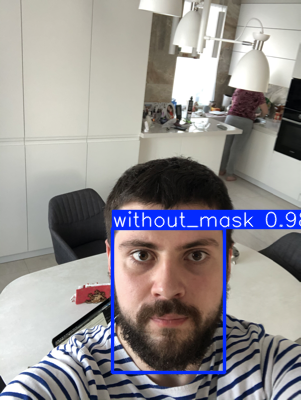

In [24]:
Image.open('/kaggle/working/Result/runs/detect/predict/maksssksksss455.png')